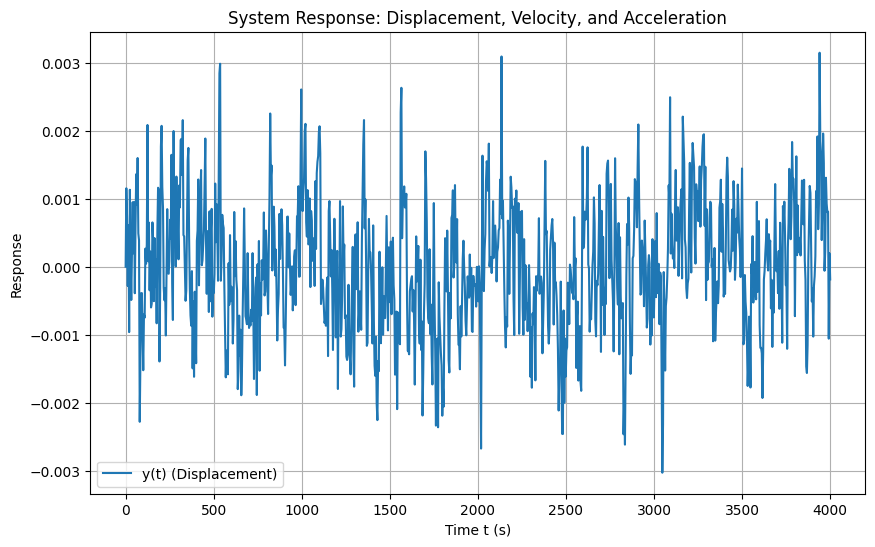

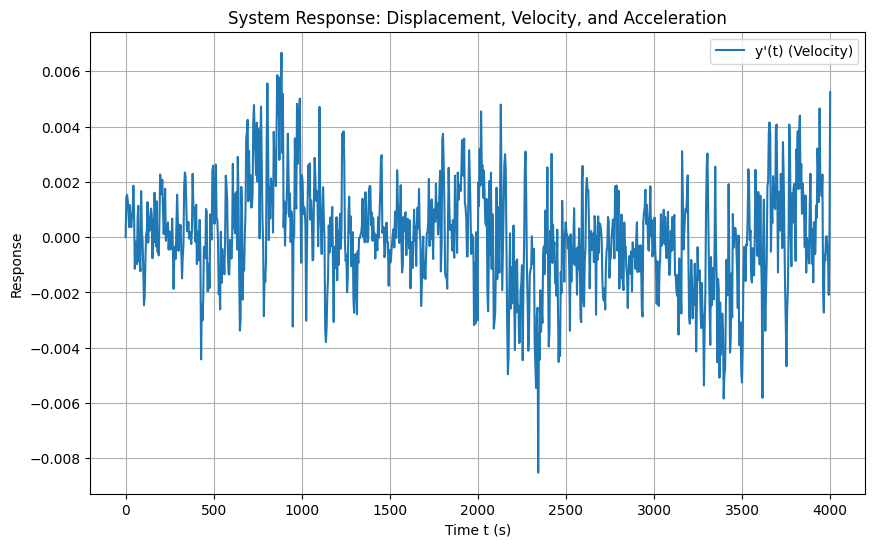

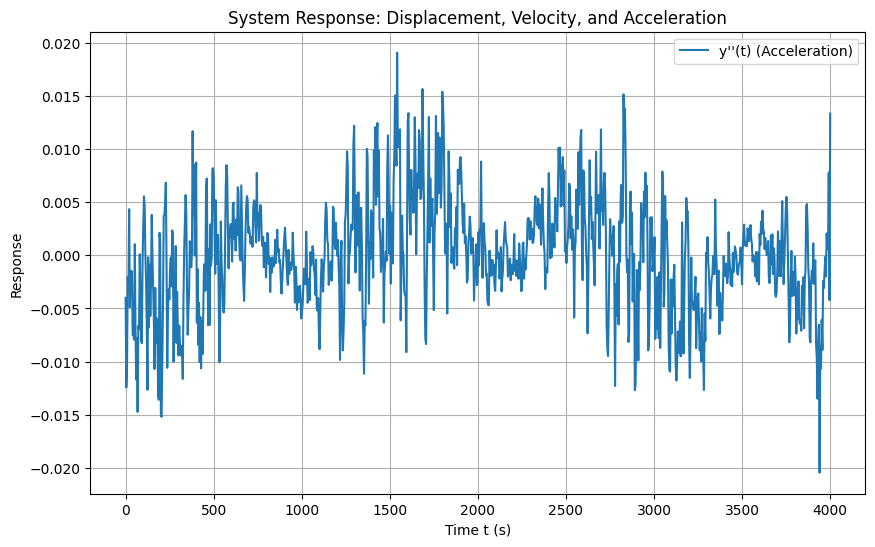

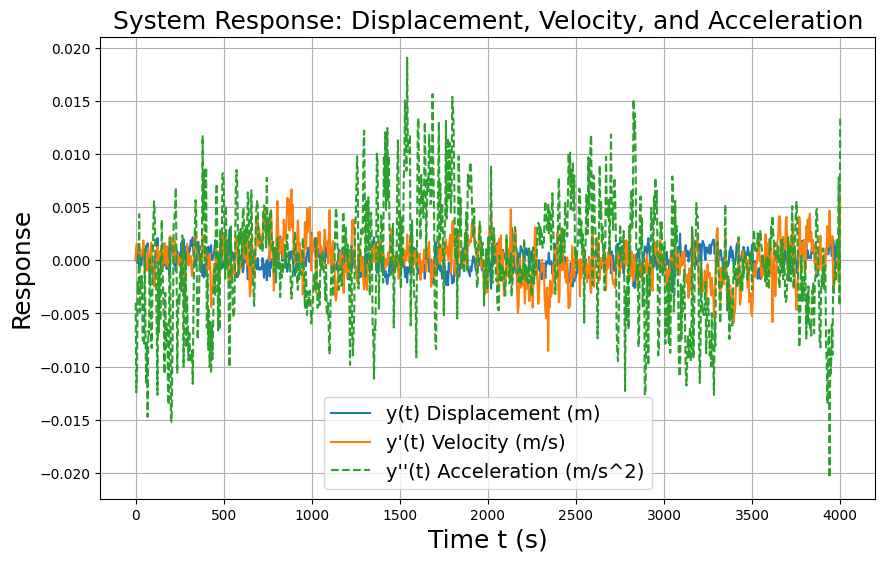

0.01904184252480344
-0.02045162218208972


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Parameters for road surface generation
m_road = 2  # Pavement Waviness Indicator
N = 1000  # Number of samples
omega0 = 1  # Spatial Reference Frequency
lower_bound = 2 * np.pi * 0.1  # Lower limit of frequency sampling
upper_bound = 2 * np.pi * 10  # Upper limit of frequency sampling

# THINGS YOU MAY CHANGE
phi_omega0 = 3E-6  # PSD value at the reference frequency (related to the road roughness - higher means rougher road)
v = 90 * 1000 / 3600  # Vehicle Speed in m/s
d = 100000 # Analysis distance in m
m = 1200  # Mass of the trailer system
k = 28400  # Trailer spring constant
c_c = np.sqrt(k*m)*2
zeta = 0.225
c = c_c*zeta # Trailer damping coefficient

timespan = d/v # Duration of analysis period in s



maxAccelSum = 0
minAccelSum = 0
maxMaxAccel = 0
minMinAccel = 0
maxAccelArray = []
minAccelArray = []

trials = 1

for i in range(trials):
    # Generate the road surface
    omega_vect = np.linspace(lower_bound, upper_bound, N)  # Frequencies to sample
    phi_vect = phi_omega0 * (omega_vect / omega0) ** -m_road
    delta_omega = (omega_vect[-1] - omega_vect[0]) / (N - 1)
    amp_vect = np.sqrt(phi_vect * (delta_omega / np.pi))

    t_vals = np.linspace(0, timespan, int(timespan))  # Time values based on speed and spatial range
    road_surface = np.zeros_like(t_vals)

    for ii in range(N):
        phase = 2 * np.pi * np.random.rand()  # Random phase shift
        road_surface += amp_vect[ii] * np.sin(omega_vect[ii] * v * t_vals - phase)

    # Interpolate the road surface
    f_interp = interp1d(t_vals, road_surface, kind='cubic', fill_value="extrapolate")

    # Compute the derivative f'(t) numerically
    f_prime_vals = np.gradient(road_surface, t_vals)
    f_prime_interp = interp1d(t_vals, f_prime_vals, kind='cubic', fill_value="extrapolate")

    # Define the forcing function f(t) = (k/m)f + (c/m)f'
    def forcing_function(t, k, m, c):
        return (k / m) * f_interp(t) + (c / m) * f_prime_interp(t)

    # Define the system of equations
    def second_order_ode(t, y, p, q, k, m, c):
        y1, y2 = y  # y1 = y, y2 = y'
        f_t = forcing_function(t, k, m, c)  # Compute the forcing function
        dydt = [y2, -p * y2 - q * y1 + f_t]  # [y', y'']
        return dydt

    # Define parameters
    p = c / m
    q = k / m

    # Initial conditions: y(0) = 1, y'(0) = 0
    y0 = [ 0, 0]

    # Solve the ODE
    t_span = (0, timespan)
    t_eval = np.linspace(0, timespan, 1000)
    solution = solve_ivp(second_order_ode, t_span, y0, t_eval=t_eval, args=(p, q, k, m, c))

    # Extract y(t) and y'(t)
    y = solution.y[0]       # y(t)
    y_dot = solution.y[1]   # y'(t)
    t = solution.t          # Time points

    # Compute the second derivative (acceleration)
    acceleration = -p * y_dot - q * y + forcing_function(t, k, m, c)

    maxAccel = max(acceleration)
    minAccel = min(acceleration)

    maxAccelSum += maxAccel
    minAccelSum += minAccel

    maxAccelArray.append(maxAccel)
    minAccelArray.append(minAccel)

    if maxAccel>maxMaxAccel:
        maxMaxAccel=maxAccel

    if minAccel<minMinAccel:
        minMinAccel=minAccel

maxAccelAvg = maxAccelSum/trials
minAccelAvg = minAccelSum/trials

# print("Average Max Acceleration:"+maxAccelAvg)
# print("Average Min Acceleration:"+minAccelAvg)

# # Specify the output file path
# output_file = 'system_response.csv'

# # Write data to CSV
# with open(output_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
    
#     # Write header
#     writer.writerow(["Time (s)", "Displacement y(t) (m)", "Velocity y'(t) (m/s)", "Acceleration y''(t) (m/s^2)"])
    
#     # Write rows of data
#     writer.writerows(data)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="y(t) (Displacement)")
plt.xlabel("Time t (s)")
plt.ylabel("Response")
plt.legend()
plt.grid()
plt.title("System Response: Displacement, Velocity, and Acceleration")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, y_dot, label="y'(t) (Velocity)")
plt.xlabel("Time t (s)")
plt.ylabel("Response")
plt.legend()
plt.grid()
plt.title("System Response: Displacement, Velocity, and Acceleration")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, acceleration, label="y''(t) (Acceleration)")
plt.xlabel("Time t (s)")
plt.ylabel("Response")
plt.legend()
plt.grid()
plt.title("System Response: Displacement, Velocity, and Acceleration")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, y, label="y(t) Displacement (m)")
plt.plot(t, y_dot, label="y'(t) Velocity (m/s)")
plt.plot(t, acceleration, label="y''(t) Acceleration (m/s^2)", linestyle="--")
plt.xlabel("Time t (s)", fontsize=18)
plt.ylabel("Response",fontsize=18)
plt.legend(fontsize=14)
plt.grid()
plt.title("System Response: Displacement, Velocity, and Acceleration",fontsize=18)
plt.show()
# Prepare data to write to CSV
data = zip(t, y, y_dot, acceleration)

maxAccel = max(acceleration)
minAccel = min(acceleration)
print(maxAccel)
print(minAccel)




In [14]:
# Define the acceleration threshold
posThreshold = 0.360239944265779  # Example threshold in m/s^2
negThreshold = -0.34004881135421067

# Count how many times the absolute value of acceleration exceeds the threshold
exceed_count = np.sum(acceleration > posThreshold)
print(f"The acceleration exceeds {posThreshold} m/s^2 a total of {exceed_count} times.")

exceed_count = np.sum(acceleration < negThreshold)
print(f"The acceleration exceeds {negThreshold} m/s^2 a total of {exceed_count} times.")


The acceleration exceeds 0.360239944265779 m/s^2 a total of 0 times.
The acceleration exceeds -0.34004881135421067 m/s^2 a total of 0 times.
